The following file includes utilities for reading the annotations from the JSON files, extracting the frames from the videos, and saving them in the dataset folder. The dataset folder is then split into train, validation, and test sets. It also includes utilities for computing the label distribution and plotting it. It also contains the dataset creation tools, that take the given annotation and create videos for each gesture phase: preparation, hold stoke, recovery. Lastly, it includes utilities for generating the "unknown" labeled videos for the dataset. The videos are split randomly between test, train and validation.

In [1]:
import numpy as np
import json

# The function takes the metadata and attributes as input and returns a list of dictionaries
# containing the gesture units, gesture phases, and bounding boxes.
    # id = 1 => PersonLocation, options = 0  (person1), 1, 2, 3 for each person
    # id = 2 => GestureUnit, options = "0": "g-unit"
    # id = 3 => GesturePhase, "options": {
    #             "0": "preparation",
    #             "1": "stroke",
    #             "2": "recovery",
    #             "3": "hold",
    #             "4": "incompleteStroke"
    #         },

    # Gesture Unit
    # 'id': 0,
    # 'timeStart': 0,
    # 'timeEnd': 25,

    # Gesture Phase
    # 'id': 0,
    # 'timeStart': 0,
    # 'timeEnd': 25,
    # 'gestureType': "recovery",

    # Bounding Box
    # 'id': 0,
    # 'position': [0.0, 0.0, 0.0, 0.0],
    # 'time': 0,
    # 'gesturePhase': "recovery",
def processMetadata(metadata, attributes):
    gestureUnits = {}
    gesturePhases = {}
    boundingBoxes = {}
    idGU = 0
    idGP = 0
    idBB = 0

    for annot in metadata:
        # it can be either the time interval of the gesture, either the time at which the bounding box appears
        # (you can deduce the frame number from this)
        zValue = metadata[annot]['z']

        # the bounding box coordinates. If it is temporal segment is empty
        xyValue = metadata[annot]['xy']

        # defines the value of each attribute for this (z, xy) combination
        # "1":"1"       # the value for attribute-id="1" is one of its option with id "1" (i.e. Activity = Break Egg)
        avValue = metadata[annot]['av']
        phasesList = []
        if len(avValue) == 1:
            attrKey = list(avValue.keys())[0]
            if(len(zValue)!=2):
                continue
            if(attrKey == '2'):
                gestureUnits[idGU] = {
                        'time': zValue,
                }
                idGU += 1
                # print("Gesture Unit annotation: ", metadata[annot])
            else:
                gesturePhases[idGP] = {
                        'time': zValue,
                        'gestureType': attributes['3']['options'][avValue[attrKey]]
                    }
                idGP += 1
                # print("Gesture Phase annotation: ", metadata[annot])
        else:
            boundingBoxes[idBB] = {
                    'position': xyValue,
                    'time': zValue,
                    'gesturePhase': attributes['3']['options'][avValue['3']],
                    'person_id': avValue['1']
                }
            idBB += 1
            # print("bounding box annotation: ", metadata[annot])
        # print("\n\n-------------------\n\n")

    # print("Gesture Units: \n")
    # for gu in gestureUnits:
    #     print(gestureUnits[gu])
    # print("\n\n-------------------\n\n")
    #
    # print("\n\n\nGesture Phases: \n")
    # for gp in gesturePhases:
    #     print(gesturePhases[gp])
    # print("\n\n-------------------\n\n")
    #
    # print("\n\n\nBounding Boxes: \n")
    # for bb in boundingBoxes:
    #     print(boundingBoxes[bb])

    return [gestureUnits, gesturePhases, boundingBoxes]


# The function reads the annotation file and processes the metadata
def readAnnotationFile(annotationFilePath):
    try:
        with open(annotationFilePath, 'r') as file:
            data = json.load(file)
        attributes = data['attribute']
        # pretty_json = json.dumps(attributes, indent=4)
        # print(pretty_json)

        [gestureUnits, gesturePhases, boundingBoxes] = processMetadata(data['metadata'], data['attribute'])
        return [gestureUnits, gesturePhases, boundingBoxes]

    except FileNotFoundError:
        print("The file was not found")
    except json.JSONDecodeError:
        print("The file contains invalid JSON")




readAnnotationFile('annotations/cam2/progressVid2-seg9/person1_annotated.json')



[{0: {'time': [0.533, 12.04257]},
  1: {'time': [13.392, 30.543]},
  2: {'time': [33.344, 35.90794]},
  3: {'time': [35.908, 36.68919]},
  4: {'time': [64.393, 66.29912]},
  5: {'time': [84.579, 87.28313]},
  6: {'time': [91.126, 91.99804]},
  7: {'time': [93.062, 94.74585]}},
 {0: {'time': [0.513, 1.996], 'gestureType': 'preparation'},
  1: {'time': [1.996, 2.66712], 'gestureType': 'stroke'},
  2: {'time': [2.667, 2.99758], 'gestureType': 'hold'},
  3: {'time': [2.998, 4.22962], 'gestureType': 'stroke'},
  4: {'time': [4.23, 4.65878], 'gestureType': 'hold'},
  5: {'time': [4.659, 5.09628], 'gestureType': 'stroke'},
  6: {'time': [5.096, 5.52962], 'gestureType': 'hold'},
  7: {'time': [5.53, 6.35045], 'gestureType': 'stroke'},
  8: {'time': [6.35, 7.42504], 'gestureType': 'stroke'},
  9: {'time': [7.425, 7.87315], 'gestureType': 'hold'},
  10: {'time': [7.873, 8.47693], 'gestureType': 'stroke'},
  11: {'time': [8.477, 8.84485], 'gestureType': 'stroke'},
  12: {'time': [8.845, 9.145], '

In [2]:
import json
import os
import cv2
import random


def asociateBBtoGPhase(boundingBoxes, gesturePhases):
    newGp = {}
    indexGp = 0
    for bb in boundingBoxes:

        for gp in gesturePhases:
            if abs(boundingBoxes[bb]['time'][0] - gesturePhases[gp]['time'][0]) <= 0.5:
                if (boundingBoxes[bb]['position'][3] < 10) or (boundingBoxes[bb]['position'][4] < 10):
                    continue
                else:
                    newGp[indexGp] = gesturePhases[gp]
                    newGp[indexGp]['boundingBox'] = boundingBoxes[bb]
                    indexGp += 1
    return newGp


def crop_frame(frame, top_left_corner, bottom_right_corner, frame_width, frame_height):
    padding = 10
    x_min, y_min = top_left_corner
    x_max, y_max = bottom_right_corner

    x_min_pad = max(0, x_min - padding)
    y_min_pad = max(0, y_min - padding)
    x_max_pad = min(frame_width, x_max + padding)
    y_max_pad = min(frame_height, y_max + padding)

    max_dif = max(x_max_pad - x_min_pad, y_max_pad - y_min_pad)

    x_max_pad = min(frame_width, x_min_pad + max_dif)
    y_max_pad = min(frame_height, y_min_pad + max_dif)

    return frame[int(y_min_pad):int(y_max_pad), int(x_min_pad):int(x_max_pad)]


def resize_frame(frame, target_size=(224, 224), interpolation=cv2.INTER_LINEAR):
    return cv2.resize(frame, target_size, interpolation=interpolation)


def extract_and_annotate_frames(video_file, annotations, index_gesture_phase_preparation, index_gesture_phase_stroke,
                                index_gesture_phase_hold, index_gesture_phase_recovery):
    [gu, gp, bb] = annotations
    gesturePhases = asociateBBtoGPhase(bb, gp)

    cap = cv2.VideoCapture(video_file)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    pathPreparation = 'dataset/preparation/'
    pathStroke = 'dataset/stroke/'
    pathHold = 'dataset/hold/'
    pathRecovery = 'dataset/recovery/'

    # list of all the frames
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append({
            'frame': frame,
            'boundingBox': None
        })

    index_gesture_phase = 0

    for annotation in gesturePhases:
        start_time = gesturePhases[annotation]['time'][0]
        end_time = gesturePhases[annotation]['time'][1]
        start_frame = int(fps * timestamp_to_seconds(start_time))
        end_frame = int(fps * timestamp_to_seconds(end_time))

        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        clip_frames = []
        # if True:
        try:
            for frameIndex in range(start_frame, end_frame + 1):
                frame = frames[frameIndex]['frame']
                bbox = gesturePhases[annotation]['boundingBox']
                bbox = [int(bbox['position'][1]), int(bbox['position'][2]), int(bbox['position'][3]),
                        int(bbox['position'][4])]
                top_left_corner, bottom_right_corner = computeBBCoord(bbox)
                croppedFrame = crop_frame(frame, top_left_corner, bottom_right_corner, frame_width, frame_height)
                resizedFrame = resize_frame(croppedFrame)
                clip_frames.append(resizedFrame)

                # cv2.rectangle(frame, top_left_corner, bottom_right_corner, (0, 255, 0), 2)
                #
                # label = f"person {gesturePhases[annotation]['boundingBox']['person_id']}: {gesturePhases[annotation]['gestureType']}"
                # cv2.putText(frame, label, (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                # Write the frame to the video
                # frames[frameIndex]['frame'] = frame

            clippedFrameWidth = clip_frames[0].shape[1]
            clippedFrameHeight = clip_frames[0].shape[0]

            output_video = ''
            if gesturePhases[annotation]['gestureType'] == 'preparation':
                output_video = pathPreparation + f"{index_gesture_phase_preparation}.mp4"
                index_gesture_phase_preparation += 1
            elif gesturePhases[annotation]['gestureType'] == 'stroke':
                output_video = pathStroke + f"{index_gesture_phase_stroke}.mp4"
                index_gesture_phase_stroke += 1
            elif gesturePhases[annotation]['gestureType'] == 'hold':
                output_video = pathHold + f"{index_gesture_phase_hold}.mp4"
                index_gesture_phase_hold += 1
            elif gesturePhases[annotation]['gestureType'] == 'recovery':
                output_video = pathRecovery + f"{index_gesture_phase_recovery}.mp4"
                index_gesture_phase_recovery += 1

            # clip_frames = adjust_clip_to_32_frames(clip_frames)
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID', 'MJPG', etc.
            out = cv2.VideoWriter(output_video, fourcc, fps, (clippedFrameWidth, clippedFrameHeight))

            if not out.isOpened():
                print(f"Error: Could not open the output video file: {output_video}")
                return

            for frame in clip_frames:
                out.write(frame)
            out.release()

        #     # print(f"Saved video: {output_video}")
        except Exception as e:
            print("clip failed")

        # if index_gesture_phase == 0:
        #     break

    cap.release()
    return [index_gesture_phase_preparation, index_gesture_phase_stroke, index_gesture_phase_hold, index_gesture_phase_recovery]


# creates annotation for unknown segments of the video whcih have length between 5-10 seconds. The annotation is saved in the dataset/unknown folder
# the time segment of an unknown segment is not annotated. It should not overlap with any other annotated segment
def annotate_unknown_segments(video_file, annotations, index_gesture_phase_unknown):
    [gu, gp, bb] = annotations
    gesturePhases = asociateBBtoGPhase(bb, gp)

    cap = cv2.VideoCapture(video_file)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    pathUnknown = 'dataset/unknown/'
    unknown_segments = []

    for index_ann in range(len(gesturePhases) - 1):

        gesture_1_end = gesturePhases[index_ann]['time'][1]
        gesture_2_start = gesturePhases[index_ann + 1]['time'][0]
        current_segment = []
        bounding_box_1 = gesturePhases[index_ann]['boundingBox']['position']
        bounding_box_2 = gesturePhases[index_ann + 1]['boundingBox']['position']

        if gesture_2_start - gesture_1_end > 5:
            bounding_box = [int(bounding_box_1[1]), int(bounding_box_1[2]), int(bounding_box_1[3]),
                            int(bounding_box_1[4])]

            random_clip_length = int(random.randint(5, min(int(gesture_2_start - gesture_1_end), 10)) * fps)
            index_start = int(gesture_1_end * fps)
            index_end = index_start + random_clip_length

            for i in range(index_start, index_end):
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                ret, frame = cap.read()
                if not ret:
                    break
                top_left_corner, bottom_right_corner = computeBBCoord(bounding_box)
                croppedFrame = crop_frame(frame, top_left_corner, bottom_right_corner, frame_width, frame_height)
                current_segment.append(croppedFrame)
            unknown_segments.append(current_segment)

        if gesture_2_start - gesture_1_end > 7:
            current_segment = []
            bounding_box = [int(bounding_box_2[1]), int(bounding_box_2[2]), int(bounding_box_2[3]),
                            int(bounding_box_2[4])]

            random_clip_length = int(random.randint(5, min(int(gesture_2_start - gesture_1_end - 2), 10)) * fps)
            index_end = int((gesture_2_start - 1) * fps)
            index_start = index_end - random_clip_length

            for i in range(index_start, index_end):
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                ret, frame = cap.read()
                if not ret:
                    break
                top_left_corner, bottom_right_corner = computeBBCoord(bounding_box)
                croppedFrame = crop_frame(frame, top_left_corner, bottom_right_corner, frame_width, frame_height)
                current_segment.append(croppedFrame)
            unknown_segments.append(current_segment)

    ### save the unknown segments in the dataset/unknown folder ###
    for segment in unknown_segments:
        if segment:
            clip_frames = segment
            clippedFrameWidth = clip_frames[0].shape[1]
            clippedFrameHeight = clip_frames[0].shape[0]

            output_video = pathUnknown + f"{index_gesture_phase_unknown}.mp4"
            index_gesture_phase_unknown += 1

            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_video, fourcc, fps, (clippedFrameWidth, clippedFrameHeight))

            if not out.isOpened():
                print(f"Error: Could not open the output video file: {output_video}")
                return

            for frame in clip_frames:
                out.write(frame)
            out.release()

    cap.release()
    return index_gesture_phase_unknown


def computeBBCoord(bb):
    x_top_left = bb[0]
    y_top_left = bb[1]
    width = bb[2]
    height = bb[3]

    x_bottom_right = x_top_left + width
    y_bottom_right = y_top_left + height

    top_left_corner = (x_top_left, y_top_left)
    bottom_right_corner = (x_bottom_right, y_bottom_right)
    return top_left_corner, bottom_right_corner


def timestamp_to_seconds(timestamp):
    return timestamp


def readAnnotationAllPersons(annotationPaths):
    annotationsPerPerson = []
    for annotationPath in annotationPaths:
        annotationPerson = readAnnotationFile(annotationPath)
        annotationsPerPerson.append(annotationPerson)
    return annotationsPerPerson


def asociateBBtoGestureUnits(boundingBoxes, gestureUnits):
    newGu = {}

    for bb in boundingBoxes:
        indexGu = 0
        for gu in gestureUnits:
            if ((abs(boundingBoxes[bb]['time'][0] - gestureUnits[gu]['time'][0]) <= 0.5)
                    or (abs(boundingBoxes[bb]['time'][0] - gestureUnits[gu]['time'][1]))
                    or (gestureUnits[gu]['time'][0] <= boundingBoxes[bb]['time'][0] <= gestureUnits[gu]['time'][1])):

                if (boundingBoxes[bb]['position'][3] < 10) or (boundingBoxes[bb]['position'][4] < 10):
                    continue
                else:
                    if indexGu not in newGu:
                        newGu[indexGu] = {
                            'gestureUnit': gestureUnits[gu],
                            'boundingBox': []
                        }
                    newGu[indexGu]['boundingBox'].append(boundingBoxes[bb])
                    indexGu += 1

    # make all bounding boxes of a gesture unit to be the same length. the new width and the new height would be the
    # maximum width and height of all bounding boxes
    for gu in newGu:
        max_width = 0
        max_height = 0
        for bb in newGu[gu]['boundingBox']:

            width = bb['position'][3]
            height = bb['position'][4]

            if width > max_width:
                max_width = width
            if height > max_height:
                max_height = height
        for bb in newGu[gu]['boundingBox']:
            bb['position'][3] = max_width
            bb['position'][4] = max_height

    return newGu


def gesture_unit_extract_and_annotate(video_file, annotations, index_gesture_units, index_gesture_noting):
    [gu, gp, bb] = annotations
    gestureUnits = asociateBBtoGestureUnits(bb, gu)

    cap = cv2.VideoCapture(video_file)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    pathGUnit = 'dataset/gunit/'
    pathNothing = 'dataset/nothing/'

    # Ensure output directories exist
    os.makedirs(pathGUnit, exist_ok=True)
    os.makedirs(pathNothing, exist_ok=True)

    # list of all the frames
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append({
            'frame': frame,
            'boundingBox': None
        })

    def extract_and_save_clip(aux_start_frame, aux_end_frame, output_path, clip_index, bb_crop):
        aux_clip_frames = []
        try:
            for aux_frameIndex in range(aux_start_frame, aux_end_frame + 1):
                aux_frame = frames[aux_frameIndex]['frame']
                aux_croppedFrame = crop_frame(aux_frame, (bb_crop[0], bb_crop[1]),
                                              (bb_crop[0] + bb_crop[2], bb_crop[1] + bb_crop[3]), frame_width,
                                              frame_height)
                aux_clip_frames.append(aux_croppedFrame)

            a_clippedFrameWidth = aux_clip_frames[0].shape[1]
            a_clippedFrameHeight = aux_clip_frames[0].shape[0]

            output_video = output_path + f"{clip_index}.mp4"
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID', 'MJPG', etc.
            out = cv2.VideoWriter(output_video, fourcc, fps, (a_clippedFrameWidth, a_clippedFrameHeight))

            if not out.isOpened():
                print(f"Error: Could not open the output video file: {output_video}")
                return

            for aux_frame in aux_clip_frames:
                out.write(aux_frame)
            out.release()

            print(f"Saved video: {output_video}")
        except Exception as e:
            print(f"Clip failed: {e}")

    def merge_bbs(bb1, bb2):
        aux_x = min(bb1[1], bb2[1])
        aux_y = min(bb1[2], bb2[2])
        aux_width = max(bb1[3], bb2[3])
        aux_height = max(bb1[4], bb2[4])
        return [aux_x, aux_y, aux_width, aux_height]

    last_end_frame = 0
    last_bound_box = None
    for annotation in gestureUnits:
        start_time = gestureUnits[annotation]['gestureUnit']['time'][0]
        end_time = gestureUnits[annotation]['gestureUnit']['time'][1]
        start_frame = int(fps * timestamp_to_seconds(start_time))
        end_frame = int(fps * timestamp_to_seconds(end_time))
        current_bound_box = gestureUnits[annotation]['boundingBox'][-1]['position']

        if start_frame - last_end_frame > 2 * fps:
            if (last_bound_box == None):
                last_bound_box = current_bound_box

            merged_bb = merge_bbs(last_bound_box, current_bound_box)

            extract_and_save_clip(last_end_frame, start_frame - 1, pathNothing, index_gesture_noting, merged_bb)
            index_gesture_noting += 1
            last_bound_box = current_bound_box

        last_end_frame = end_frame + 1
        clip_frames = []
        try:
            for frameIndex in range(start_frame, end_frame + 1):
                frame = frames[frameIndex]['frame']
                bbox = None
                frameTime = int(frameIndex / fps)
                # set the bbox as the bounding box that has the time closest to the frame time
                minDiff = float('inf')
                for bb in gestureUnits[annotation]['boundingBox']:
                    if abs(bb['time'][0] - frameTime) < minDiff:
                        minDiff = abs(bb['time'][0] - frameTime)
                        bbox = bb

                bbox = [int(bbox['position'][1]), int(bbox['position'][2]), int(bbox['position'][3]),
                        int(bbox['position'][4])]
                top_left_corner, bottom_right_corner = computeBBCoord(bbox)
                croppedFrame = crop_frame(frame, top_left_corner, bottom_right_corner, frame_width, frame_height)
                resizedFrame = resize_frame(croppedFrame)
                clip_frames.append(resizedFrame)

            clippedFrameWidth = clip_frames[0].shape[1]
            clippedFrameHeight = clip_frames[0].shape[0]

            output_video = pathGUnit + f"{index_gesture_units}.mp4"
            index_gesture_units += 1

            fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID', 'MJPG', etc.
            out = cv2.VideoWriter(output_video, fourcc, fps, (clippedFrameWidth, clippedFrameHeight))

            if not out.isOpened():
                print(f"Error: Could not open the output video file: {output_video}")
                return

            for frame in clip_frames:
                out.write(frame)
            out.release()

            print(f"Saved video: {output_video}")
        except Exception as e:
            print(f"Clip failed: {e}")

    if len(frames) - last_end_frame > 2 * fps:
        extract_and_save_clip(last_end_frame, len(frames) - 1, pathNothing, index_gesture_noting, last_bound_box)
        index_gesture_noting += 1

    cap.release()
    return [index_gesture_units, index_gesture_noting]


if __name__ == "__main__":
    video_paths = [
        {
            'video_path': 'annotations/cam2/progressVid2-seg9/vid2-seg9-scaled-denoised.mp4',
            'annotation_paths': [
                'annotations/cam2/progressVid2-seg9/person1_annotated.json',
                'annotations/cam2/progressVid2-seg9/person2_annotated.json',
                'annotations/cam2/progressVid2-seg9/person3_annotated.json',
                'annotations/cam2/progressVid2-seg9/person4_annotated.json',
                'annotations/cam2/progressVid2-seg9/person5_annotated.json',
                'annotations/cam2/progressVid2-seg9/person6_annotated.json',
                'annotations/cam2/progressVid2-seg9/person7_annotated.json',
                'annotations/cam2/progressVid2-seg9/person8_annotated.json'
            ]
        },
        {
            'video_path': 'annotations/cam2/progressVid3-seg1/vid3-seg1-scaled-denoised.mp4',
            'annotation_paths': [
                'annotations/cam2/progressVid3-seg1/person1_annotated.json',
                'annotations/cam2/progressVid3-seg1/person2_annotated.json',
                'annotations/cam2/progressVid3-seg1/person3_annotated.json'
            ]
        },
        {
            'video_path': 'annotations/cam4/vid2-seg8-scaled-denoised.mp4',
            'annotation_paths': [
                'annotations/cam4/person1_annotated.json',
            ]
        },
        {
            'video_path': 'annotations/cam6/vid2-seg8-scaled-denoised.mp4',
            'annotation_paths': [
                'annotations/cam6/person1_annotated.json',
            ]
        },
    ]

    index_gesture_phase_preparation = 0
    index_gesture_phase_stroke = 0
    index_gesture_phase_hold = 0
    index_gesture_phase_recovery = 0
    index_gesture_phase_unknown = 0
    index_gesture_units = 0
    index_gesture_noting = 0

    if True:
        for video_path in video_paths:
            video_file = video_path['video_path']
            annotationPaths = video_path['annotation_paths']
            # video_file = video_path
            annotations = readAnnotationAllPersons(annotationPaths)

            # if True:
            for i in range(len(annotations)):
                # [index_gesture_phase_preparation, index_gesture_phase_stroke, index_gesture_phase_hold,
                #  index_gesture_phase_recovery] = extract_and_annotate_frames(video_file, annotations[0],
                #                                                              index_gesture_phase_preparation,
                #                                                              index_gesture_phase_stroke,
                #                                                              index_gesture_phase_hold,
                #                                                              index_gesture_phase_recovery)
                # index_gesture_phase_unknown = annotate_unknown_segments(video_file, annotations[0],
                #                                                         index_gesture_phase_unknown)
                [index_gesture_units, index_gesture_noting] = gesture_unit_extract_and_annotate(video_file,
                                                                                                annotations[i],
                                                                                                index_gesture_units,
                                                                                                index_gesture_noting)
                print("!!!!!!!!!!!!!Annotated person " + str(i + 1))

            print("----Annotated video " + video_file)


Saved video: dataset/gunit/0.mp4
Saved video: dataset/gunit/1.mp4
Saved video: dataset/nothing/0.mp4
Saved video: dataset/gunit/2.mp4
Saved video: dataset/gunit/3.mp4
Saved video: dataset/nothing/1.mp4
Saved video: dataset/gunit/4.mp4
Saved video: dataset/nothing/2.mp4
Saved video: dataset/gunit/5.mp4
Saved video: dataset/nothing/3.mp4
Saved video: dataset/gunit/6.mp4
Saved video: dataset/gunit/7.mp4
Saved video: dataset/nothing/4.mp4
!!!!!!!!!!!!!Annotated person 1
Saved video: dataset/nothing/5.mp4
Saved video: dataset/gunit/8.mp4
Saved video: dataset/nothing/6.mp4
Saved video: dataset/gunit/9.mp4
Saved video: dataset/gunit/10.mp4
Saved video: dataset/gunit/11.mp4
Saved video: dataset/nothing/7.mp4
Saved video: dataset/gunit/12.mp4
Saved video: dataset/nothing/8.mp4
Saved video: dataset/gunit/13.mp4
Saved video: dataset/nothing/9.mp4
Saved video: dataset/gunit/14.mp4
!!!!!!!!!!!!!Annotated person 2
Saved video: dataset/gunit/15.mp4
Saved video: dataset/gunit/16.mp4
Saved video: datas

In [ ]:
import os
import random
import shutil
from collections import defaultdict

def split_data(files, split_ratio):
    random.shuffle(files)
    total_files = len(files)
    train_split = int(total_files * split_ratio[0])
    val_split = int(total_files * split_ratio[1])
    train_files = files[:train_split]
    val_files = files[train_split:train_split + val_split]
    test_files = files[train_split + val_split:]
    return train_files, val_files, test_files

dataset_path = "dataset"
output_path = "dataset_final"
subfolders = ["hold", "recovery", "preparation", "stroke", "unknown"]

for split in ["train", "val", "test"]:
    for subfolder in subfolders:
        os.makedirs(os.path.join(output_path, split, subfolder), exist_ok=True)

for subfolder in subfolders:
    folder_path = os.path.join(dataset_path, subfolder)
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    train_files, val_files, test_files = split_data(files, (0.7, 0.15, 0.15))

    for f in train_files:
        shutil.copy(os.path.join(folder_path, f), os.path.join(output_path, "train", subfolder, f))
    for f in val_files:
        shutil.copy(os.path.join(folder_path, f), os.path.join(output_path, "val", subfolder, f))
    for f in test_files:
        shutil.copy(os.path.join(folder_path, f), os.path.join(output_path, "test", subfolder, f))

print("Dataset split completed!")

Total number of videos: 1455
Total number of videos in train: 1015
Total number of videos in val: 216
Total number of videos in test: 224

Distribution for train:
  hold: 125 files (12.32%)
  recovery: 81 files (7.98%)
  preparation: 28 files (2.76%)
  stroke: 737 files (72.61%)
  unknown: 44 files (4.33%)

Distribution for val:
  hold: 26 files (12.04%)
  recovery: 17 files (7.87%)
  preparation: 6 files (2.78%)
  stroke: 158 files (73.15%)
  unknown: 9 files (4.17%)

Distribution for test:
  hold: 28 files (12.50%)
  recovery: 19 files (8.48%)
  preparation: 7 files (3.12%)
  stroke: 159 files (70.98%)
  unknown: 11 files (4.91%)



/tmp/ipykernel_3606920/2590793398.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(subfolders, rotation=45, ha='right')
/tmp/ipykernel_3606920/2590793398.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(subfolders, rotation=45, ha='right')
/tmp/ipykernel_3606920/2590793398.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(subfolders, rotation=45, ha='right')


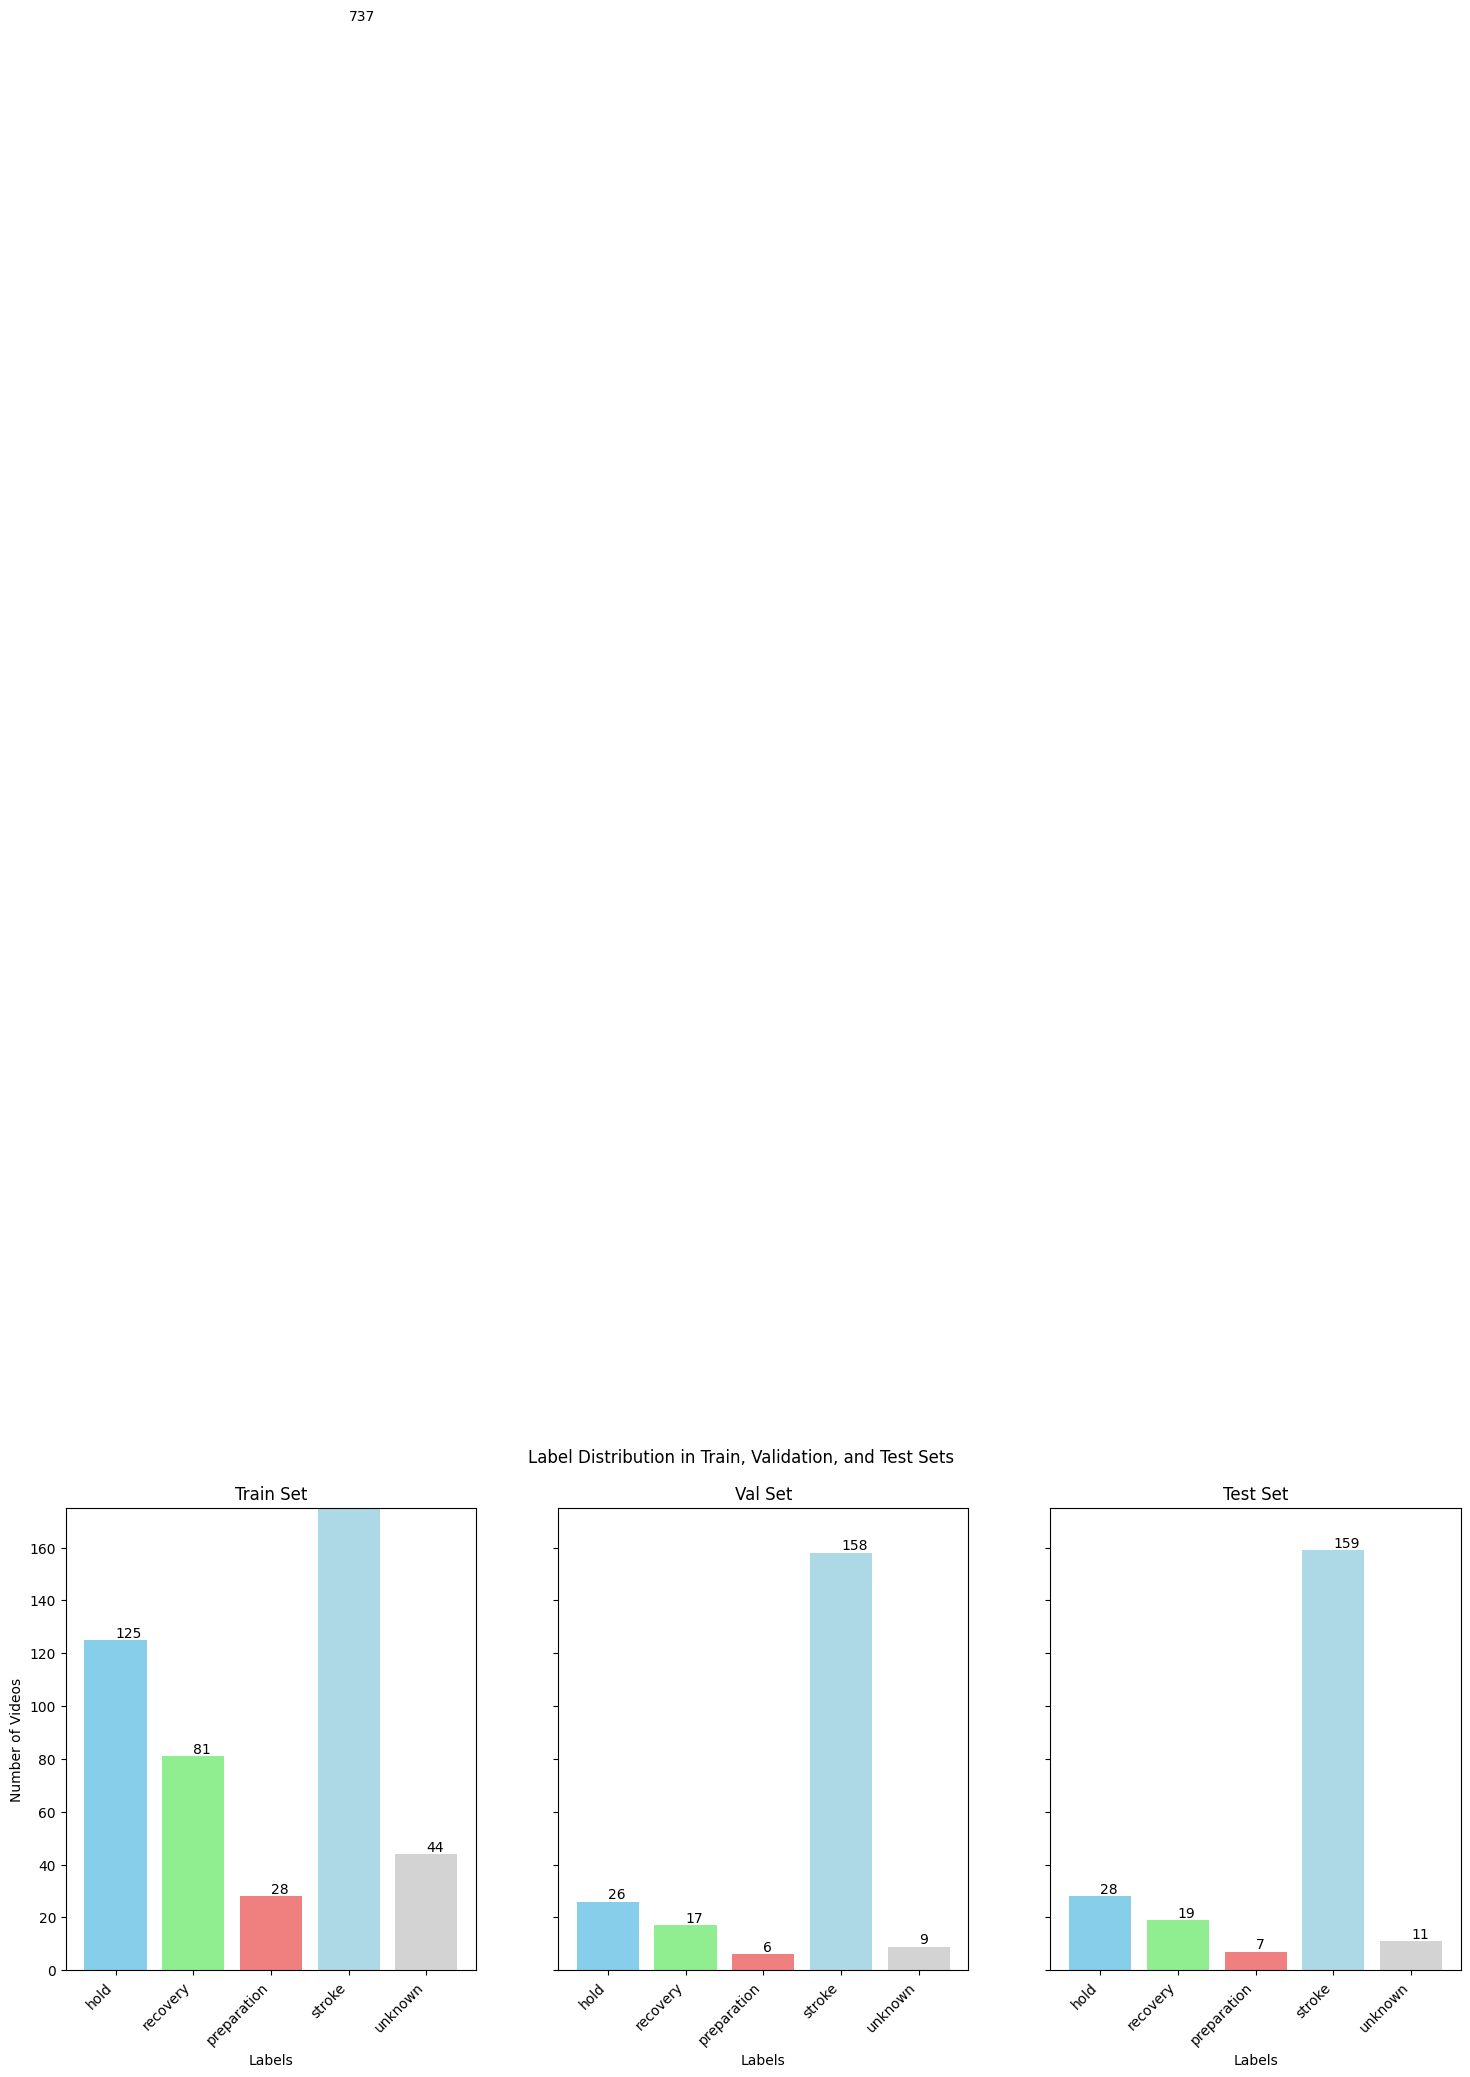

In [10]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict

def compute_label_distribution(base_path):
    splits = ["train", "val", "test"]
    subfolders = ["hold", "recovery", "preparation", "stroke", "unknown"]

    distribution = {split: defaultdict(int) for split in splits}
    total_counts = {split: 0 for split in splits}

    for split in splits:
        for subfolder in subfolders:
            folder_path = os.path.join(base_path, split, subfolder)
            
            if not os.path.exists(folder_path):
                raise FileNotFoundError(f"The subfolder path {folder_path} does not exist.")
            
            num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            distribution[split][subfolder] += num_files
            total_counts[split] += num_files

    total_videos = sum(total_counts.values())
    print(f"Total number of videos: {total_videos}")
    for split in splits:
        print(f"Total number of videos in {split}: {total_counts[split]}")
    print()
    
    for split in splits:
        print(f"Distribution for {split}:")
        for subfolder in subfolders:
            count = distribution[split][subfolder]
            total = total_counts[split]
            percentage = (count / total) * 100 if total > 0 else 0
            print(f"  {subfolder}: {count} files ({percentage:.2f}%)")
        print()
    
    return distribution

def plot_label_distribution(distribution):
    splits = list(distribution.keys())
    subfolders = list(distribution[splits[0]].keys())

    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    for i, split in enumerate(splits):
        counts = [distribution[split][subfolder] for subfolder in subfolders]
        bars = axs[i].bar(subfolders, counts, color=['skyblue', 'lightgreen', 'lightcoral', 'lightblue', 'lightgray'])
        axs[i].set_title(f'{split.capitalize()} Set')
        axs[i].set_xlabel('Labels')
        axs[i].set_ylabel('Number of Videos' if i == 0 else '')
        axs[i].set_ylim(0, max(max(counts) * 1.1, 1))
        axs[i].set_xticklabels(subfolders, rotation=45, ha='right')

        for bar in bars:
            yval = bar.get_height()
            axs[i].text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  

    plt.suptitle('Label Distribution in Train, Validation, and Test Sets')
    plt.show()

base_path = "dataset_final"
distribution = compute_label_distribution(base_path)
plot_label_distribution(distribution)


Total number of videos: 194
Total number of videos in train: 135
Total number of videos in val: 28
Total number of videos in test: 31

Distribution for train:
  gunit: 82 files (60.74%)
  nothing: 53 files (39.26%)

Distribution for val:
  gunit: 17 files (60.71%)
  nothing: 11 files (39.29%)

Distribution for test:
  gunit: 19 files (61.29%)
  nothing: 12 files (38.71%)



/tmp/ipykernel_3627271/3415307112.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(subfolders, rotation=45, ha='right')
/tmp/ipykernel_3627271/3415307112.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(subfolders, rotation=45, ha='right')
/tmp/ipykernel_3627271/3415307112.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(subfolders, rotation=45, ha='right')


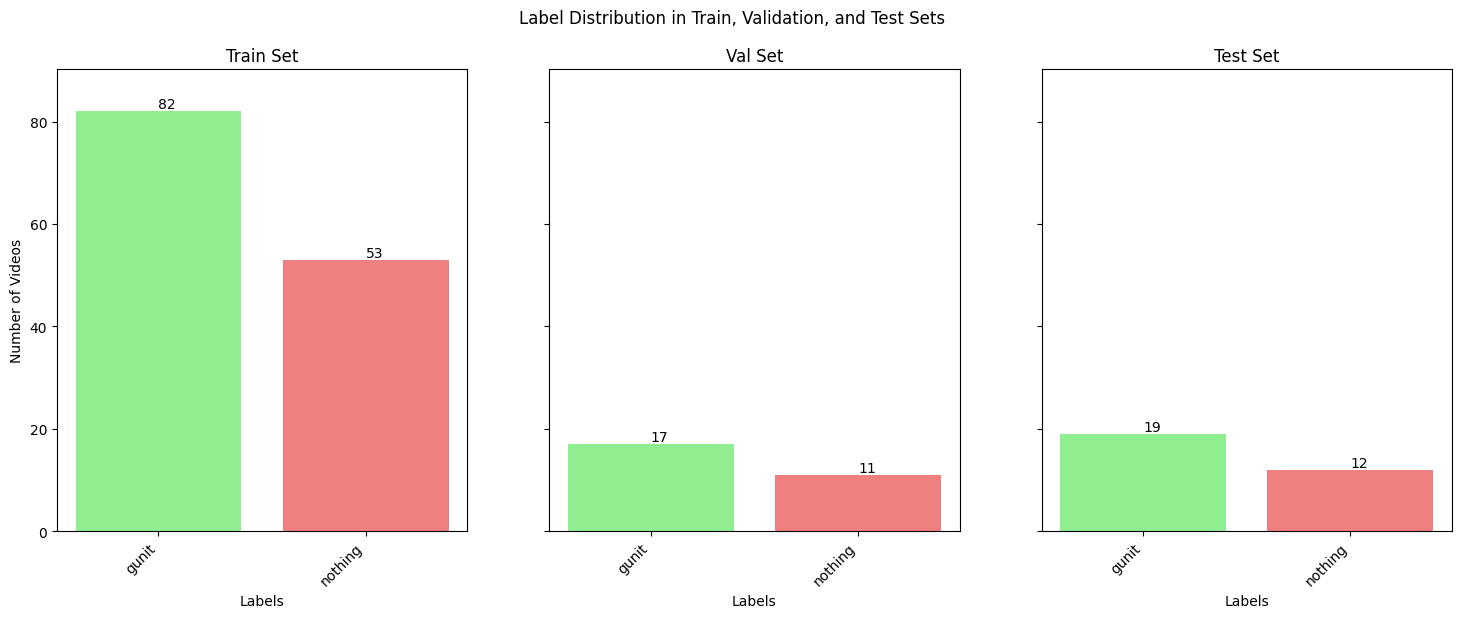

In [4]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict

def compute_label_distribution(base_path):
    splits = ["train", "val", "test"]
    subfolders = ["gunit", "nothing"]

    # Dictionary to hold the count of each label in each split
    distribution = {split: defaultdict(int) for split in splits}
    total_counts = {split: 0 for split in splits}

    # Iterate over each split
    for split in splits:
        for subfolder in subfolders:
            folder_path = os.path.join(base_path, split, subfolder)
            
            # Verify subfolder path exists
            if not os.path.exists(folder_path):
                raise FileNotFoundError(f"The subfolder path {folder_path} does not exist.")
            
            # Count the number of files in the subfolder
            num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            distribution[split][subfolder] += num_files
            total_counts[split] += num_files

    # Print the distribution
    total_videos = sum(total_counts.values())
    print(f"Total number of videos: {total_videos}")
    for split in splits:
        print(f"Total number of videos in {split}: {total_counts[split]}")
    print()
    
    for split in splits:
        print(f"Distribution for {split}:")
        for subfolder in subfolders:
            count = distribution[split][subfolder]
            total = total_counts[split]
            percentage = (count / total) * 100 if total > 0 else 0
            print(f"  {subfolder}: {count} files ({percentage:.2f}%)")
        print()
    
    return distribution

def plot_label_distribution(distribution):
    splits = list(distribution.keys())
    subfolders = list(distribution[splits[0]].keys())

    # Find the maximum value among all splits for consistent y-axis limits
    max_count = max(max(distribution[split][subfolder] for subfolder in subfolders) for split in splits)

    # Create the plot
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    for i, split in enumerate(splits):
        counts = [distribution[split][subfolder] for subfolder in subfolders]
        bars = axs[i].bar(subfolders, counts, color=['lightgreen', 'lightcoral'])
        axs[i].set_title(f'{split.capitalize()} Set')
        axs[i].set_xlabel('Labels')
        axs[i].set_ylabel('Number of Videos' if i == 0 else '')
        axs[i].set_ylim(0, max(max_count * 1.1, 1))  # Use max_count for y-axis limit
        axs[i].set_xticklabels(subfolders, rotation=45, ha='right')

        # Add text annotations
        for bar in bars:
            yval = bar.get_height()
            axs[i].text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment

    plt.suptitle('Label Distribution in Train, Validation, and Test Sets')
    plt.show()


# Assuming 'dataset_final' is the base path, print the label distribution and plot it
base_path = "dataset_gunit"
distribution = compute_label_distribution(base_path)
plot_label_distribution(distribution)